## Ridesharing Project

In [577]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.core.population import Population
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.core.repair import Repair
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling
from pymoo.core.selection import Selection
from pymoo.util.misc import random_permuations
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.factory import get_reference_directions, get_selection
from pymoo.core.individual import Individual

<ipython-input-578-0c22a12252e0>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


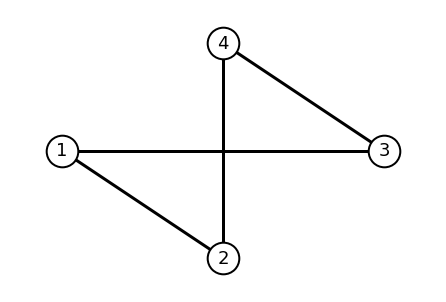

In [578]:
# graph of the map
# for visualisation

# load graph from a file
def map_graph(f_name):
    G = nx.Graph()
    G.add_weighted_edges_from([(1, 2, 12.5), (1, 3, 75), (2, 4, 29), (3, 4, 151)])
    return G

def show_graph(g, color_map = None):
    options = {
        "font_size": 18,
        "node_size": 1000,
        "edgecolors": "black",
        "linewidths": 2,
        "width": 3,
    }
    if color_map:
        options["node_color"]=color_map
    else:
        options["node_color"]="white"
    
    nx.draw_shell(g, with_labels=True, **options)
    ax = plt.gca()
    ax.margins(0.11)
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    
MG = map_graph("example_map.txt")
show_graph(MG)



   index  s  t  et
0      0  2  3  10
1      1  1  3  30
2      2  4  2   5


<ipython-input-578-0c22a12252e0>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


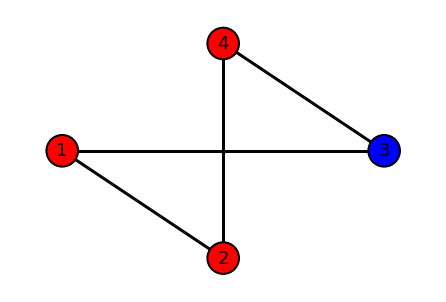

In [579]:
# model of riders 

# rider info from a data file
# file format: index s t et
def load_riders(f_name): 
    riders = pd.read_csv(f_name, sep= " ", header= None, index_col= 0)
    riders.columns=["index","s","t", "et"]
    return riders

# for testing
riders = pd.DataFrame(np.array([[0, 2, 3, 10], [1, 1, 3, 30], [2, 4, 2, 5]]), columns=['index', 's', 't', 'et'])
print(riders)

#for visualisation
def show_riders(mg, riders):
    color_map =[]
    for n in mg:
        if n in riders['s'].to_numpy():
            color_map.append('red')
        elif n in riders['t'].to_numpy():
            color_map.append('blue')
        else:
            color_map.append('white')
    show_graph(mg, color_map)

show_riders(MG, riders)

In [580]:
# vehicles

def cal_unit_cost(h):
    return 0

def cal_emission_rate(h):
    return 0

# vehicle info from a data file
# file format: index s t p type, fuel
# e is an array, which represents the emission rate of the vehicle per passenger per distance
def load_vehicles(f_name):
    vehicles = pd.read_csv(f_name, sep= " ", header= None, index_col= 0)
    vehicles.columns=["index","s","t", "p", "e", "c"]
    return vehicles

# for testing
vehicles = pd.DataFrame([[0, 1, 3, 1, [1, 1.1], 1], [1, 2, 1, 2, [1.8, 2, 2.1], 1.2]])
vehicles.columns=['index', 's', 't', 'p', 'e', 'c']

print(vehicles.iloc[[0,1]])

   index  s  t  p              e    c
0      0  1  3  1       [1, 1.1]  1.0
1      1  2  1  2  [1.8, 2, 2.1]  1.2


In [581]:
def rs_sampling(mg, riders, vehicles):
    max_weight = 100
    n_var = riders.shape[0]
    speed = 2
    r = riders.shape[0]
    v = vehicles.shape[0]
    
    solution = np.empty((0,3), int)
    arr_path = dict()
    
    for i in range(r):
        chro = np.array([-1,-1,-1])
        driver = np.random.randint(v)
        chro[0] = driver
        chro[1] = max_weight * np.random.random_sample()
        chro[2] = max_weight * np.random.random_sample()
        solution = np.append(solution, [chro], axis=0)
    
    print(solution)
    
    arr = solution[:,0]
    travel_length = [] 
    travel_load = []
    travel_record = []

    for i in range(v):
        vehicle = vehicles.iloc[i]
        pas_index = np.where(arr == i)[0]
        num = len(pas_index)
        record = np.zeros((num*2+2), dtype=int)
        record[0] = -1
        record[-1] = -1
        path = np.zeros((num*2+2), dtype=int)
        path[0] = vehicle['s']
        path[-1] = vehicle['t']
        pas = np.zeros((num*2+2), dtype=int)
        length = np.zeros((num*2+2), dtype=int)
        wait = np.zeros((num*2+2), dtype=int)

        board = dict()
        hold = dict()
        for i in pas_index:
            hold[i] = solution[i]

        for j in range(1, len(path)-1, 1):
            off_weight = -1
            drop_rider = 0
            for key in board.keys():
                if off_weight < board[key][2]:
                    off_weight = board[key][2]
                    drop_rider = key

            on_weight = -1
            pick_rider = 0
            for key in hold.keys():
                if on_weight < hold[key][2]:
                    on_weight = hold[key][2]
                    pick_rider = key

            if np.sum(pas) < vehicle['p']:
                if off_weight >= on_weight:
                    path[j] = riders.iloc[drop_rider]['t']
                    board.pop(drop_rider, None)
                    pas[j] = pas[j-1] - 1
                    record[j] = drop_rider

                else:
                    path[j] = riders.iloc[pick_rider]['s']
                    board[pick_rider] = solution[pick_rider]
                    hold.pop(pick_rider, None)
                    pas[j] = pas[j-1] + 1
                    record[j] = pick_rider
                    
                    wait_time = np.sum(wait)
                    tra_dis = nx.dijkstra_path_length(mg, path[j-1], path[j])
                    tra_time = (np.sum(length) + tra_dis) / speed
                    wait[j] = riders.iloc[pick_rider]['et'] - (wait_time + tra_time) # >0, vehicle wait, < 0, rider wait

            else:
                path[j] = riders.iloc[drop_rider]['t']
                board[pick_rider] = solution[pick_rider]
                pas[j] = pas[j-1] - 1
                record[j] = drop_rider

            length[j] = nx.dijkstra_path_length(mg, path[j-1], path[j])
        length[-1] = nx.dijkstra_path_length(mg, path[-2], path[-1])
        travel_record.append(record)
        travel_length.append(length) 
        travel_load.append(pas)
        arr_path[i] = path
        
    return travel_record, travel_length, travel_load, arr_path

print(riders)
rs_sampling(MG, riders, vehicles)

   index  s  t  et
0      0  2  3  10
1      1  1  3  30
2      2  4  2   5
[[ 1 99 79]
 [ 0 31 91]
 [ 1 92  4]]


([array([-1,  1,  1, -1]), array([-1,  0,  0,  2,  2, -1])],
 [array([ 0,  0, 75,  0]), array([  0,   0,  87, 116,  29,  12])],
 [array([0, 1, 0, 0]), array([0, 1, 0, 1, 0, 0])],
 {1: array([1, 1, 3, 3]), 2: array([2, 2, 3, 4, 2, 1])})

vehicle 1: v.s -> compare (r0.99, r2.92) -> r0.s -> compare (r0.79, r2.92) -> r2.s (if no higher than capacity) / r0.t (otherwise) 

another case, if compare (r0.99, r2.92) -> r0.t  

# Define the problem
problem: find an arrangement for the riders and vehicles
solution: 3 x riders.shape[0]

In [582]:
class RideSharing(ElementwiseProblem):
    def __init__(self, mg, riders, vehicles):
        n_var = riders.shape[0]
        self.mg = mg
        self.speed = 2
        self.riders = riders
        self.vehicles = vehicles
        self.r = riders.shape[0]
        self.v = vehicles.shape[0]
        self.shape = np.array([self.r, 3])
        
        super().__init__(n_var=self.r, n_obj=6, n_constr=0, xl=0, xu=n_var-1)
    
    
    # emission calculation: vehicle v's emission of driving via a path
    def _emit(self, h, length, load):
        em_rate = h['e']
        pas = 0
        ems = 0
        for i in range(len(length)):
            cur_e = em_rate[pas]
            ems += cur_e * length[i]
            pas = load[i]
        
        return 0
    
    
    # calculate the gini coefficiency, 
    def _gini(self, a):
        a = a.flatten()
        if np.amin(a) < 0:
            a -= np.amin(a)
        a += 0.0000001
        a = np.sort(a)
        index = np.arange(1,a.shape[0]+1)
        n = a.shape[0]
        return ((np.sum((2 * index - n  - 1) * a)) / (n * np.sum(a)))
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        # 1. get the arrangement for each vehicle 
        arr = x[:,0]
        travel_length = [] 
        travel_load = []
        travel_record = []
        travel_wait = []

        for i in range(self.v):
            vehicle = self.vehicles.iloc[i]
            pas_index = np.where(arr == i)[0]
            num = len(pas_index)
            record = np.zeros((num*2+2), dtype=int)
            record[0] = -1
            record[-1] = -1
            path = np.zeros((num*2+2), dtype=int)
            path[0] = vehicle['s']
            path[-1] = vehicle['t']
            pas = np.zeros((num*2+2), dtype=int)
            length = np.zeros((num*2+2), dtype=int)
            wait = np.zeros((num*2+2), dtype=int)

            board = dict()
            hold = dict()
            for i in pas_index:
                hold[i] = x[i]

            for j in range(1, len(path)-1, 1):
                off_weight = -1
                drop_rider = -1
                
                for key in board.keys():
                    if off_weight < board[key][2]:
                        off_weight = board[key][2]
                        drop_rider = key

                on_weight = -1
                pick_rider = -1
                for key in hold.keys():
                    if on_weight < hold[key][2]:
                        on_weight = hold[key][2]
                        pick_rider = key

                if pas[j-1] < vehicle['p']:
                    if off_weight >= on_weight:
                        path[j] = self.riders.iloc[drop_rider]['t']
                        board.pop(drop_rider, None)
                        pas[j] = pas[j-1] - 1
                        record[j] = drop_rider

                    else:
                        path[j] = self.riders.iloc[pick_rider]['s']
                        board[pick_rider] = x[pick_rider]
                        hold.pop(pick_rider, None)
                        pas[j] = pas[j-1] + 1
                        record[j] = pick_rider
                        
                        wait_time = np.sum(wait)
                        tra_dis = nx.dijkstra_path_length(self.mg, path[j-1], path[j])
                        tra_time = (np.sum(length) + tra_dis) / self.speed
                        wait[j] = self.riders.iloc[pick_rider]['et'] - (wait_time + tra_time) 
                        # >0, vehicle wait, < 0, rider wait

                else:
                    path[j] = self.riders.iloc[drop_rider]['t']
                    board.pop(drop_rider, None)
                    pas[j] = pas[j-1] - 1
                    record[j] = drop_rider

                length[j] = nx.dijkstra_path_length(self.mg, path[j-1], path[j])
            length[-1] = nx.dijkstra_path_length(self.mg, path[-2], path[-1])
            
            travel_record.append(record)
            travel_length.append(length) 
            travel_load.append(pas)
            travel_wait.append(wait)

        # 3. objectives
        # 1-EW, 2-ET
        ew = 0
        et = 0
        # and work time of vehicles, to include the time of waiting to pick up a rider into working time
        work_time = np.zeros((self.v), dtype = float)
        
        for i in range(self.r):
            driver = x[i][0]
            stops = np.where(travel_record[driver] == i)[0]
            wait = travel_wait[driver]
            s_stop = stops[0]
            t_stop = stops[1]
            if wait[s_stop] < 0:
                ew += 0 - wait[s_stop]
            else:
                work_time[driver] += wait[s_stop]
            
            travel_dis = np.sum(travel_length[driver][s_stop+1:t_stop+1])
            et += travel_dis / self.speed
        #end of for loop
        
        # 3-EC, 4-ED, 5-SE
        ec = 0
        ed = 0
        se = 0
        for i in range(self.v):
            h = self.vehicles.iloc[i]
            dis = np.sum(travel_length[i])
            work_time[i] += dis / self.speed
            ec += dis * h['c'] # assume here we have the cost per distance
            short_dis = nx.dijkstra_path_length(self.mg, h['s'], h['t'])
            ed += dis - short_dis
            se += self._emit(h, travel_length[i], travel_load[i])

        # 6-SG
        sg = self._gini(work_time)
        
        out["F"] = [ew, et, ec, ed, se, sg]
        


In [583]:
# use repair to make sure the algorithm is only searching in the feasible space.
#class ConsiderMaximumWeightRepair(Repair):
#    def _do(self, problem, pop, **kwargs):
#        arr = pop.get("X")
#        z = np.array([])
#        pop.set("X", Z)
#        return pop

In [584]:
rs_problem = RideSharing(MG, riders, vehicles)
print(rs_problem.v)

2


# Modefy NSGA3 
samiling, selection, crossover, mutation and elimination

In [585]:
# NSGA3 algorithm
init_size = 8
sele_rate = 0.5
offspring_size = init_size * sele_rate

In [586]:
# 1 define the initial populations
class RSSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        n_var = problem.riders.shape[0]
        speed = problem.speed
        r = problem.r
        v = problem.v
        pop = np.empty((0, r, 3), int)        
        
        for i in range(n_samples):            
            solution = np.empty((0,3), int)
    
            for i in range(r):
                chro = np.array([-1,-1,-1])
                driver = np.random.randint(v)
                chro[0] = driver
                chro[1] = 100 * np.random.random_sample()
                chro[2] = 100 * np.random.random_sample()
                solution = np.append(solution, [chro], axis=0)
            
            pop = np.append(pop, [solution], axis=0)
        
        print("Successfully init the samplings!")
        return pop

In [587]:
# 2 define the selection
class RSSelection(Selection):
    def _do(self, pop, n_select, n_parents, **kwargs):
        # number of random individuals needed
        n_random = n_select * n_parents
        n_perms = math.ceil(n_random / len(pop))
        P = random_permuations(n_perms, len(pop))[:n_random]
        X = np.reshape(P, (n_select, n_parents))
        return X

In [588]:
# 3 define the cross over
# crossover: two parents to one offspring
class RSCrossover(Crossover):
    def __init__(self, pattern_index):
        super().__init__(2, 1)
        self.pattern_index = pattern_index

    def _do(self, problem, X, **kwargs):
        shape = X.shape # n_offsprings, n_matings, problem.var
        _X = np.full((self.n_offsprings, shape[1], shape[2], shape[3]), int)
        Y = np.empty((0, shape[2], 3), int)
        parent_A = X[0]
        parent_B = X[1]
        for i in range(shape[1]):
            a_offspring = np.empty((0,3), int)
            A = parent_A[i]
            B = parent_B[i]
            parts = self.pattern_index + 1
            num = int(len(A) / parts) + 1
            for i in range(parts):
                from_p = num * i
                to_p = num * i + num
                if to_p > len(A):
                    to_p = len(A)
                if i % 2 == 0:
                    a_offspring = np.append(a_offspring, A[from_p:to_p, :], axis = 0)
                else:
                    a_offspring = np.append(a_offspring, B[from_p:to_p, :], axis = 0)
            Y = np.append(Y, [a_offspring], axis = 0)
        
        _X[0] = Y
        print("Successfully processed the crosscover!")
        return _X

In [589]:
# 4 define the mutation
# mutation: one riders change its drivers
class RSMutation(Mutation):
    def do(self, problem, X, **kwargs):
        Y = np.empty((0,3), int)
        for i in range(int(len(X)/2)):
            rider = X[i].X
            rider[0] = np.random.randint(problem.v)
            rider[1] += 100 * np.random.random_sample()
            rider[2] += 100 * ( np.random.random_sample() + 0.01 )
            
            Y = np.append(Y, [rider], axis = 0)
        Y = np.reshape(Y, (int(len(Y)/problem.r), problem.r, 3))
        print("Successfully processed the mutation!")  
        return Y

In [590]:
# Define the method to elimintae duplicated soltuions
class RS_eliminate_duplicates(ElementwiseDuplicateElimination):
    def is_equal(self, a, b):
        if isinstance(a, Individual):
            a_s = a.X
        else:
            a_s = a
            
        if isinstance(b, Individual):
            b_s = b.X
        else:
            b_s = b
        
        diff = len(np.where((a_s - b_s) != 0)[0])
        if diff > 0:
            return False
        else:
            return True
        
        return False
            
            
    def _do(self, pop, other, is_duplicate):
        def to_float(val):
            if isinstance(val, bool) or isinstance(val, np.bool_):
                return 0.0 if val else 1.0
            else:
                return val

        if other is None:
            for i in range(len(pop)):
                for j in range(i + 1, len(pop)):
                    val = self.cmp(pop[i], pop[j])
                    if val:
                        is_duplicate[i] = True
                        break
        else:
            for i in range(len(pop)):
                for j in range(len(other)):
                    val = self.cmp(pop[i], other[j])
                    if val:
                        is_duplicate[i] = True
                        break
        print("Successfully eliminated duplications")
        return is_duplicate

In [591]:
ref_dirs = get_reference_directions("das-dennis", 6, n_partitions=1)
rs_algorithm = NSGA3(pop_size = init_size,
                     ref_dirs = ref_dirs,
                     sampling = RSSampling(),
                     selection = RSSelection(),
                     crossover = RSCrossover(1),
                     mutation = RSMutation(),
                     eliminate_duplicates = RS_eliminate_duplicates(),
                     n_offsprings = offspring_size
                    )

In [594]:
# optimization and visualisation 
n_gen = 10
res = minimize(rs_problem,
               rs_algorithm,
               termination=('n_gen', n_gen),
               seed=1,
               save_history=True,
               verbose=True)
X = res.X
F = res.F
print(X)
print(F)

Successfully init the samplings!
Successfully eliminated duplications
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |       8 |       1 |            - |            -
Successfully processed the crosscover!
Successfully processed the mutation!
Successfully eliminated duplications
Successfully eliminated duplications
    2 |      12 |       1 |  0.00000E+00 |            f
Successfully processed the crosscover!
Successfully processed the mutation!
Successfully eliminated duplications
Successfully eliminated duplications
    3 |      16 |       1 |  1.00000E+01 |        ideal
Successfully processed the crosscover!
Successfully processed the mutation!
Successfully eliminated duplications
Successfully eliminated duplications
    4 |      20 |       1 |  0.00000E+00 |            f
Successfully processed the crosscover!
Successfully processed the mutation!
Successfully eliminated duplications
Successfully eliminated duplications
    5 |      24 |       1 |  0.00000E+00 |        

input part variation: Different type of riders:
(1) similar weight
(2) similar leaving time (maybe real-time)
(3) number of riders
(4) similar starting point
(5) similar/diversed destination

Different type of vehicles:
(1) vehicle capacities
(2) distribution of their starting points

Different rate of riders and vehicles

Alg Part variation: 
crossover and mutation

objectives variation/comparison from 3 aspects:
turn on or off the emission one

In [149]:
# problem: find an arrangement for the riders and vehicles
# solution: 3 x riders.shape[0]
class RideSharing(Problem):
    def __init__(self, mg, riders, vehicles):
        n_var = 2*riders.shape[0]+2*vehicles.shape[0]
        self.mg = mg
        self.speed = 2
        self.riders = riders
        self.vehicles = vehicles
        self.r = riders.shape[0]
        self.v = vehicles.shape[0]
        for i in range(self.r):
            self.index[2*i] = riders.iloc[i]['s']
            self.index[2*i + 1] = riders.iloc[i]['t']
        for i in range(self.r, self.r + self.v):
            self.index[2*i] = vehicles.iloc[i]['s']
            self.index[2*i + 1] = vehicls.iloc[i]['t']
        
        super().__init__(n_var=n_var, n_obj=6, n_constr=vehicles.shape[0], xl=0, xu=n_var-1)
    
    # calculate the path of a vehicle
    # @vehicle: the vehicle, @arr_riders: the nodes to stop by to pick up and drop off riders.
    # length: an array, record the distance that the vehicle travels at each stop.
    # load: an array, record the number of passengers on the vehicle when the vehicle arraive each stop.
    def _get_travel_path(vehicle, arr_path):
        length, load = np.array([])
        s = self.index[arr_path[0]]
        pas = 0
        np.append(length, 0)
        np.append(load, 0)
        for i in range(1, len(arr_path)):
            t = self.index[arr_path[i]]
            if arr_riders[i] % 2 == 0::
                pas += 1
            else:
                pas -= 1
            np.append(length, nx.dijkstra_path_length(self.mg, s, t))
            np.append(load, pas)
            
        return length, load
        
    # emission calculation: vehicle v's emission of driving via a path
    def _emit(h, length, load):
        ems = 0
        em_rate = h['e']
        for i in range(len(length)):
            pas = load[i]
            cur_e = em_rate[pas]
            ems += length[i] * cur_e
        return 0
    
    # calculate the gini coefficiency, 
    def _gini(a):
        a = a.flatten()
        if np.amin(a) < 0:
            a -= np.amin(a)
        a += 0.0000001
        a = np.sort(a)
        index = np.arange(1,a.shape[0]+1)
        n = array.shape[0]
        return ((np.sum((2 * index - n  - 1) * a)) / (n * np.sum(a)))
    
    def _evaluate(self, x, out, *args, **kwargs):        
        # 1. get the arrangement for each vehicle 
        # [0,1,2,3,4,5]
        # [4, 0, 2, 3, 1, 5]
        x = np.array(x)
        arr_paths = dict()
        v_index = 0
        for i in range(self.r, self.r + self.v):
            vehicle_s = np.where(a == 2*i)[0][0]
            vehicle_t = np.where(a == 2*i+1)[0][0]
            arr_paths[v_index] = x[vehicle_s: vehicle_t]
            v_index += 1
        
        # 2. get the travel path for an arrangement
        travel_length, travel_load = []
        for i in arr_riders.keys():
            length, load = _get_travel_path(self.vehicles.iloc[i], arr_paths[i])
            travel_length.add(length) 
            travel_load.add(load)
        
        # 3. objectives
        # 1-EW, 2-ET
        ew, et = 0
        for i in range(self.v):
            cur_dis = 0
            for j in range(1, len(arr_paths[i])-1):
                cur_dis += travel_length[j]
                a_stop = arr_paths[i][j]
                if a_stop % 2 == 0:
                    rider = a_stop / 2
                    pick_time = cur_dis / self.speed
                    if pick_time >= self.riders.iloc[rider]['et']:
                        ew += pick_time - self.riders.iloc[rider]['et']
                    drop_stop = np.where(arr_paths[i] == a_stop + 1)[0][0]
                    travel_dis = np.sum(travel_length[j:drop_stop])
                    et += travel_dis / self.speed
        #end of for loop
        
        # 3-EC, 4-ED, 5-SE
        ec, ed = 0
        work_time = np.array([])
        for i in range(self.v):
            h = self.vehicles.iloc[i]
            dis = np.sum(travel_length[i])
            work_time.append(dis/self.speed)
            # question here: does waiting time count as working time?
            ec += dis * h['c'] # assume here we have the cost per distance
            short_dis = nx.dijkstra_path_length(self.mg, h['s'], h['t'])
            ed += dis - short_dis
            se += _emit(h, travel_length[i], travel_load[i])

        # 6-SG
        sg = _gini(work_time)
        
        out["F"] = [ew, et, ec, ed, se, sg]
        



arr_vehicles = arr_riders[0]
for i in range(len(y)):
    if i != 0:
        arr_vehicles=np.vstack((arr_vehicles,arr_riders[i]))
        arr_vehicles = arr_vehicles.T
                    
            path = travel_paths[h_id]
            length = travel_length[h_id]
            s = self.riders.iloc[i]['s']
            t = self.riders.iloc[i]['t']
            cur_dis = 0 # distance from the starting point of a vehicle to current node
            tra_dis = 0 # distance from picking up a rider to its detination
            picked = False
            for k in range(len(path)):
                cur_dis += length[k]
                if picked:
                    tra_dis += length[k]
                if path[k] == s & picked == False:
                    cur_time = cur_dis/self.speed
                    if cur_time >= self.riders.iloc[i]['et']:
                        ew += cur_time - self.riders.iloc[i]['et']
                        picked = True
                        continue
                if path[k] == t & picked == True:
                    et += tra_dis/self.speed
                    break

SyntaxError: invalid syntax (<ipython-input-149-3aebbefc4e98>, line 33)